# Tableaux de bord

Ce notebook propose des visualisations avancées et des indicateurs de performance pour le projet BI.

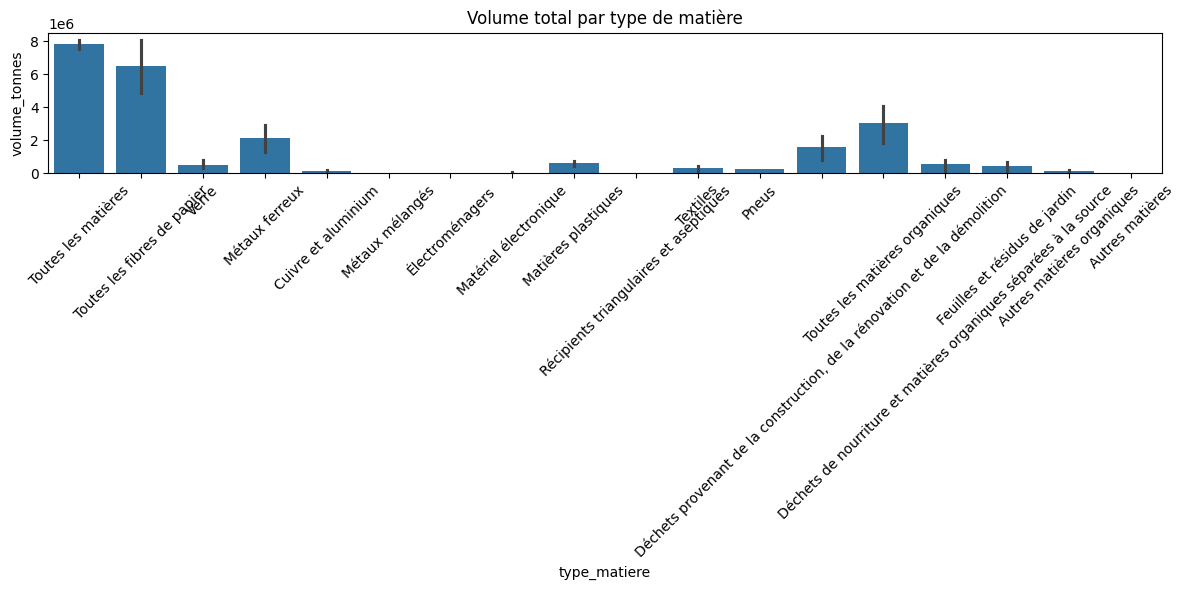

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Créer le dossier d'export si nécessaire
os.makedirs('../generated/graphs', exist_ok=True)

faits_matieres = pd.read_csv('../generated/faits_matieres.csv')

plt.figure(figsize=(12,6))
sns.barplot(data=faits_matieres, x='type_matiere', y='volume_tonnes', estimator=sum)
plt.xticks(rotation=45)
plt.title('Volume total par type de matière')
plt.tight_layout()
plt.savefig('../generated/graphs/volume_par_type_matiere.png')
plt.show()

Volume total par producteur :
producteur
Toutes les sources des matières récupérées            16215582.0
Sources des matières non résidentielles récupérées     4026293.0
Sources des matières résidentielles récupérées         4022227.0
Name: volume_tonnes, dtype: float64


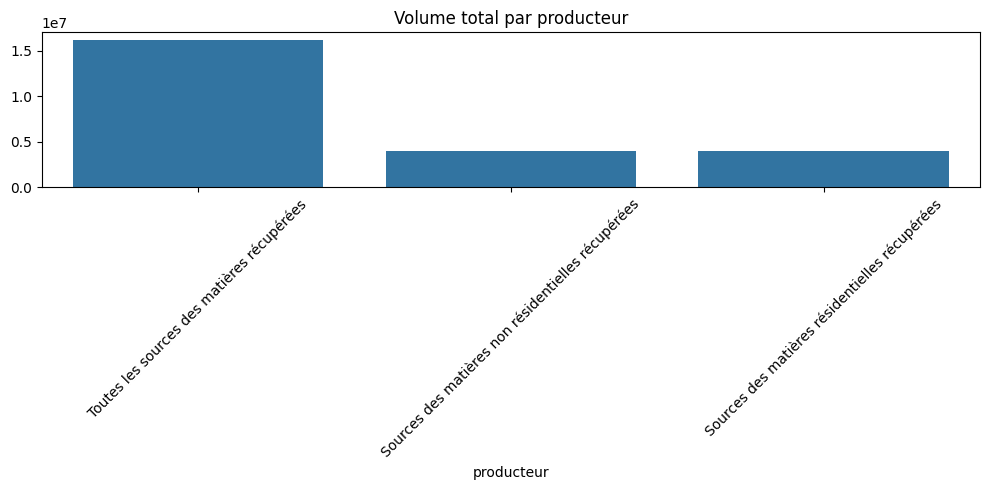

Volume total par période :
periode
2022    9105766.0
2020    7736341.0
2018    7421995.0
Name: volume_tonnes, dtype: float64


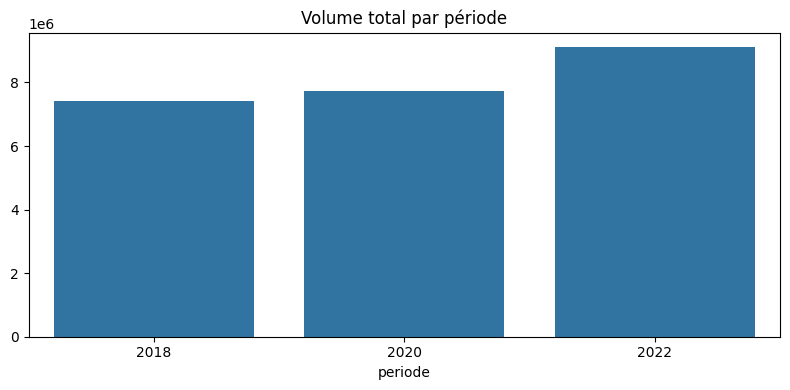

Top 5 types de matières par volume :
type_matiere
Toutes les matières                                                           7827640.0
Toutes les fibres de papier                                                   6480800.0
Toutes les matières organiques                                                3078074.0
Métaux ferreux                                                                2168244.0
Déchets provenant de la construction, de la rénovation et de la démolition    1615370.0
Name: volume_tonnes, dtype: float64


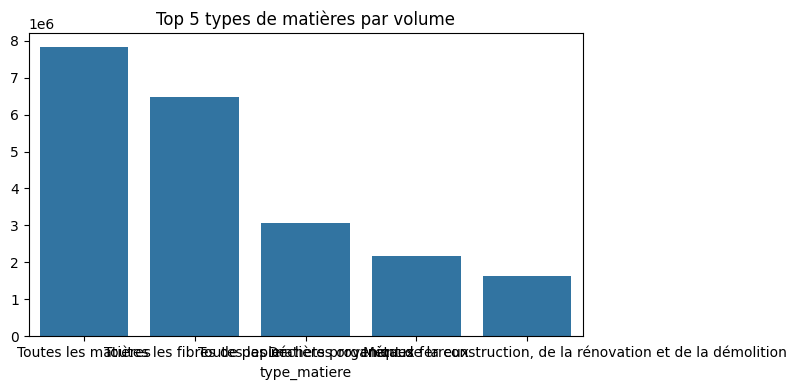

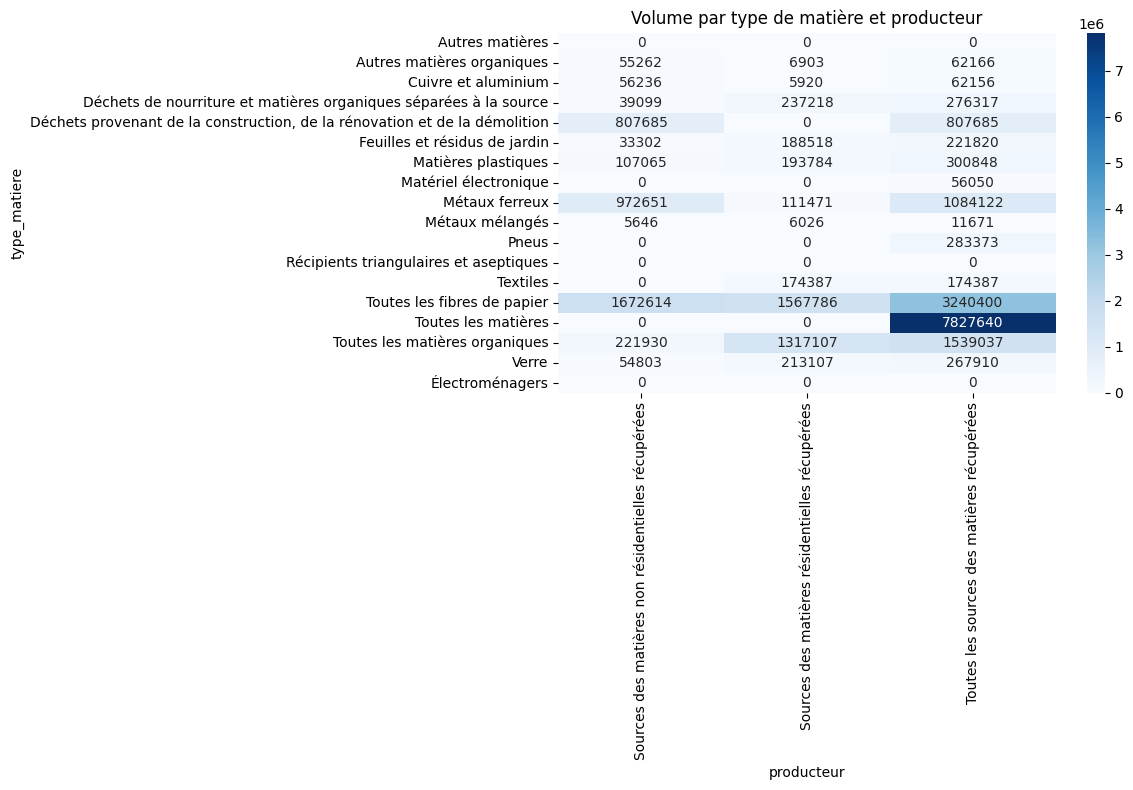

In [2]:
# KPI : Volume total par producteur
total_volume_producteur = faits_matieres.groupby('producteur')['volume_tonnes'].sum().sort_values(ascending=False)
print("Volume total par producteur :")
print(total_volume_producteur)

plt.figure(figsize=(10,5))
sns.barplot(x=total_volume_producteur.index, y=total_volume_producteur.values)
plt.xticks(rotation=45)
plt.title('Volume total par producteur')
plt.tight_layout()
plt.savefig('../generated/graphs/volume_par_producteur.png')
plt.show()

# KPI : Volume total par période
total_volume_periode = faits_matieres.groupby('periode')['volume_tonnes'].sum().sort_values(ascending=False)
print("Volume total par période :")
print(total_volume_periode)

plt.figure(figsize=(8,4))
sns.barplot(x=total_volume_periode.index, y=total_volume_periode.values)
plt.title('Volume total par période')
plt.tight_layout()
plt.savefig('../generated/graphs/volume_par_periode.png')
plt.show()

# KPI : Top 5 types de matières par volume
top5_matieres = faits_matieres.groupby('type_matiere')['volume_tonnes'].sum().sort_values(ascending=False).head(5)
print("Top 5 types de matières par volume :")
print(top5_matieres)

plt.figure(figsize=(8,4))
sns.barplot(x=top5_matieres.index, y=top5_matieres.values)
plt.title('Top 5 types de matières par volume')
plt.tight_layout()
plt.savefig('../generated/graphs/top5_types_matiere.png')
plt.show()

# Heatmap : Volume par type de matière et producteur
pivot = faits_matieres.pivot_table(index='type_matiere', columns='producteur', values='volume_tonnes', aggfunc='sum', fill_value=0)
plt.figure(figsize=(12,8))
sns.heatmap(pivot, annot=True, fmt='.0f', cmap='Blues')
plt.title('Volume par type de matière et producteur')
plt.tight_layout()
plt.savefig('../generated/graphs/heatmap_volume_type_producteur.png')
plt.show()

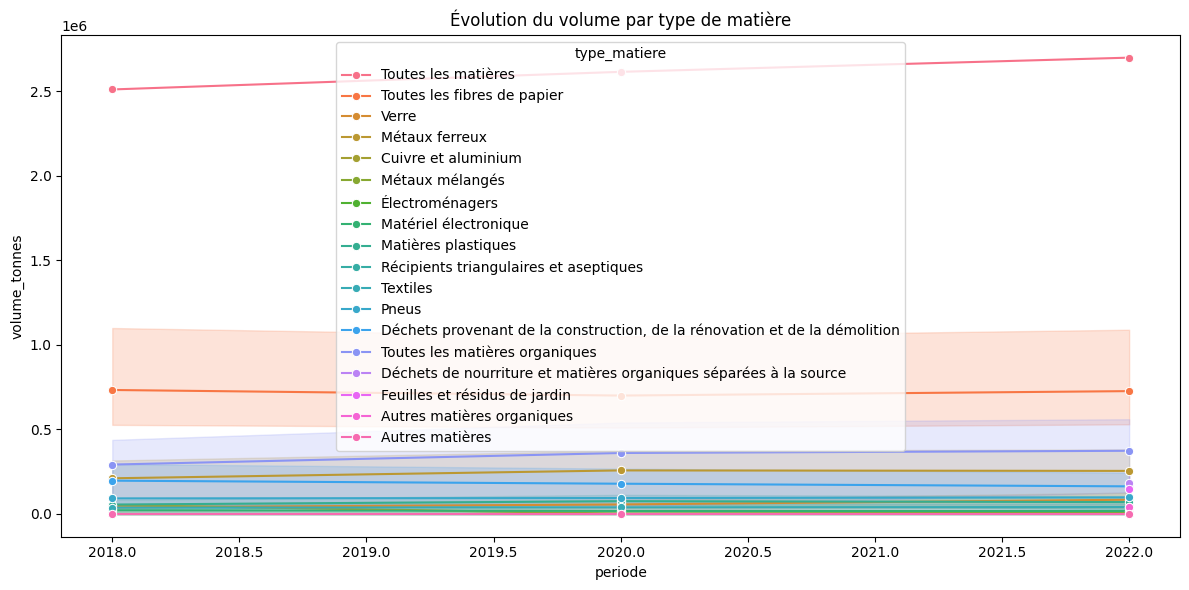

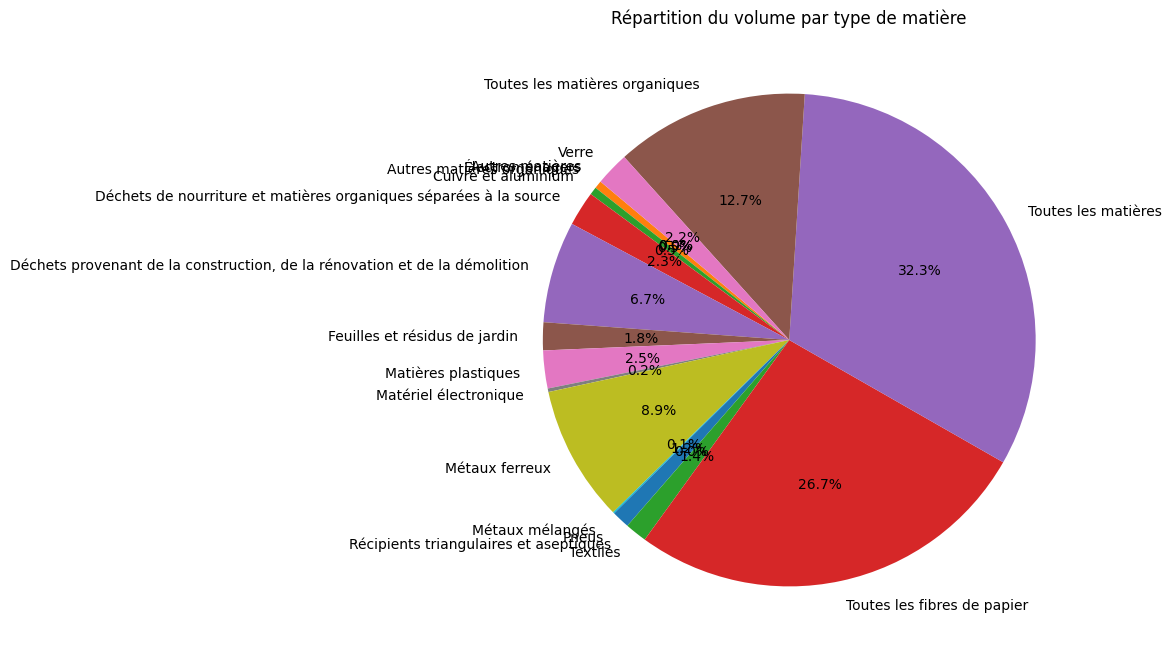

Volume moyen par producteur:
producteur
Toutes les sources des matières récupérées            337824.625000
Sources des matières résidentielles récupérées        105848.078947
Sources des matières non résidentielles récupérées    103238.282051
Name: volume_tonnes, dtype: float64
Volume moyen par type de matière:
type_matiere
Toutes les matières                                                           2.609213e+06
Toutes les fibres de papier                                                   7.200889e+05
Toutes les matières organiques                                                3.420082e+05
Métaux ferreux                                                                2.409160e+05
Déchets de nourriture et matières organiques séparées à la source             1.842113e+05
Déchets provenant de la construction, de la rénovation et de la démolition    1.794856e+05
Feuilles et résidus de jardin                                                 1.478800e+05
Pneus                               

/tmp/ipykernel_352125/263546868.py:27: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top3 = top_producteurs_par_matiere.groupby('type_matiere').apply(lambda x: x.nlargest(3, 'volume_tonnes')).reset_index(drop=True)
/tmp/ipykernel_352125/263546868.py:38: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


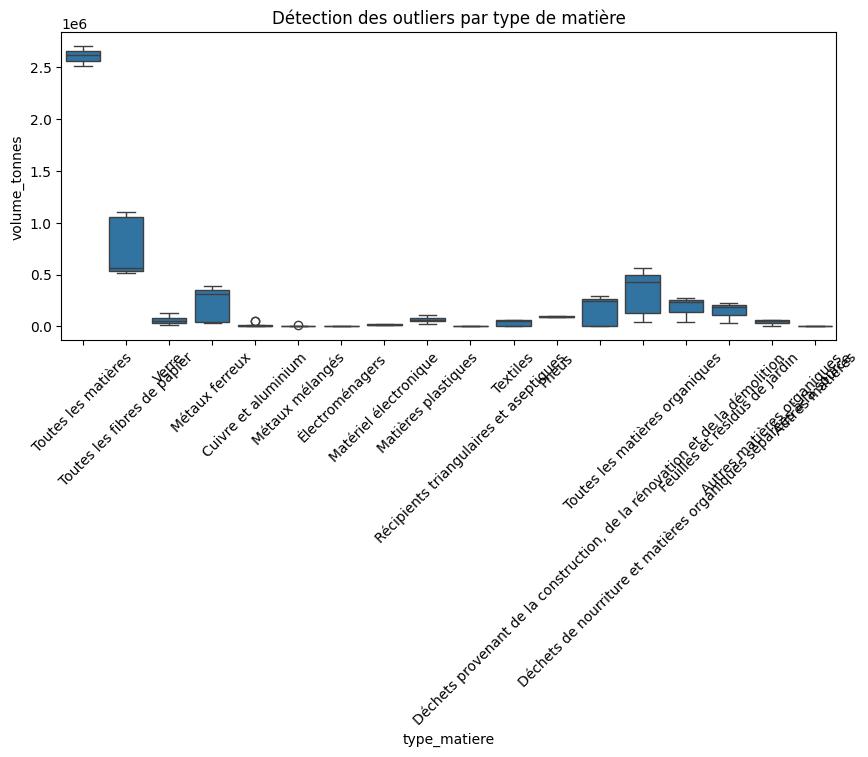

Aperçu interactif des faits:


,periode,geo,type_matiere,producteur,volume_tonnes
0,2018,Québec,Toutes les matières,Toutes les sources des matières récupérées,2511744.0
1,2020,Québec,Toutes les matières,Toutes les sources des matières récupérées,2615931.0
2,2022,Québec,Toutes les matières,Toutes les sources des matières récupérées,2699965.0
3,2018,Québec,Toutes les matières,Sources des matières résidentielles récupérées,NaN
4,2020,Québec,Toutes les matières,Sources des matières résidentielles récupérées,NaN
5,2022,Québec,Toutes les matières,Sources des matières résidentielles récupérées,NaN
6,2018,Québec,Toutes les matières,Sources des matières non résidentielles récupé...,NaN
7,2020,Québec,Toutes les matières,Sources des matières non résidentielles récupé...,NaN
8,2022,Québec,Toutes les matières,Sources des matières non résidentielles récupé...,NaN
9,2018,Québec,Toutes les fibres de papier,Toutes les sources des matières récupérées,1100000.0


In [3]:
# Évolution du volume par type de matière au fil des années
plt.figure(figsize=(12,6))
sns.lineplot(data=faits_matieres, x='periode', y='volume_tonnes', hue='type_matiere', marker='o')
plt.title('Évolution du volume par type de matière')
plt.tight_layout()
plt.savefig('../generated/graphs/evolution_volume_type_matiere.png')
plt.show()

# Répartition (%) par type de matière (pie chart)
volumes = faits_matieres.groupby('type_matiere')['volume_tonnes'].sum()
plt.figure(figsize=(8,8))
plt.pie(volumes, labels=volumes.index, autopct='%1.1f%%', startangle=140)
plt.title('Répartition du volume par type de matière')
plt.savefig('../generated/graphs/repartition_volume_type_matiere.png')
plt.show()

# Volume moyen par producteur et par type de matière
mean_volume_producteur = faits_matieres.groupby('producteur')['volume_tonnes'].mean().sort_values(ascending=False)
mean_volume_matiere = faits_matieres.groupby('type_matiere')['volume_tonnes'].mean().sort_values(ascending=False)
print('Volume moyen par producteur:')
print(mean_volume_producteur)
print('Volume moyen par type de matière:')
print(mean_volume_matiere)

# Top 3 producteurs par type de matière
top_producteurs_par_matiere = faits_matieres.groupby(['type_matiere', 'producteur'])['volume_tonnes'].sum().reset_index()
top3 = top_producteurs_par_matiere.groupby('type_matiere').apply(lambda x: x.nlargest(3, 'volume_tonnes')).reset_index(drop=True)
print('Top 3 producteurs par type de matière:')
print(top3)

# Analyse des valeurs manquantes et outliers
print('Valeurs manquantes par colonne:')
print(faits_matieres.isnull().sum())
plt.figure(figsize=(10,4))
sns.boxplot(data=faits_matieres, x='type_matiere', y='volume_tonnes')
plt.xticks(rotation=45)
plt.title('Détection des outliers par type de matière')
plt.tight_layout()
plt.savefig('../generated/graphs/outliers_type_matiere.png')
plt.show()

# Tableau interactif (si Jupyter/IPython)
from IPython.display import display
print('Aperçu interactif des faits:')
display(faits_matieres.head(20))